# Day of the Month Seasonality

Simple investigation whether going long on several days of the month are better than others.

Key Code Assumptions:
- Data contains all working days, such that the number of the business day can be inferred purely based on the 'Date' column
- Metrics are computed on the price at the close
- The return on the data is the total return, and does not include other aspects such as dividends or coupons

### Imports and Initialization

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
### PARAMETERS ###
PERIOD_AHEAD = 250

### CONSTANTS ###
SORTED_DAYNAMES = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

In [27]:
DATA = (
    pd.read_csv('../data/VANGUARD_US_CORPORATE_1to3Y_BOND.csv')
    .loc[:,['Date', 'Close']]
)

DATA['Date'] = (
    pd.to_datetime(DATA['Date'], format='%d-%m-%Y')
)

display(DATA)

,Date,Close
0,2019-02-19,50.000000
1,2019-02-20,50.000099
2,2019-02-21,50.105000
3,2019-02-22,50.150002
4,2019-02-25,50.169998
...,...,...
1494,2025-01-21,57.889999
1495,2025-01-22,57.860001
1496,2025-01-23,58.020000
1497,2025-01-24,57.970001


### Working Day Number

For clarity: the working day number represents how many working days there were before the current working day, counting from the start of the month. Indexing starts at zero.

In [28]:
series_working_dates = DATA.copy()

series_working_dates['Year_Month'] =(
    series_working_dates['Date'].dt.to_period('M')
)

series_working_dates = (
    series_working_dates
    .groupby(['Year_Month'])
    .cumcount()
    # .groupby(0)
    # .count()
)

display(series_working_dates)

0        0
1        1
2        2
3        3
4        4
        ..
1494    13
1495    14
1496    15
1497    16
1498    17
Length: 1499, dtype: int64

### Add Day Indices

Current indices are:
- Num_Workday: the working day number
- Day_Name: the 'dd' number of the date from a yyyy-mm-dd date
- Day_Name: the name of the day, i.e. Monday, Tuesday, ...

In [29]:
data_working_day = (
    DATA
    .copy()
)

data_working_day['Num_Workday'] = series_working_dates

data_working_day['Day_Name'] = data_working_day['Date'].dt.day_name()

data_working_day['Day_Number'] = data_working_day['Date'].dt.day

display(data_working_day)

,Date,Close,Num_Workday,Day_Name,Day_Number
0,2019-02-19,50.000000,0,Tuesday,19
1,2019-02-20,50.000099,1,Wednesday,20
2,2019-02-21,50.105000,2,Thursday,21
3,2019-02-22,50.150002,3,Friday,22
4,2019-02-25,50.169998,4,Monday,25
...,...,...,...,...,...
1494,2025-01-21,57.889999,13,Tuesday,21
1495,2025-01-22,57.860001,14,Wednesday,22
1496,2025-01-23,58.020000,15,Thursday,23
1497,2025-01-24,57.970001,16,Friday,24


### Compute Returns

Columns produced:
- Single_Period_Ahead_Return: return over one row ahead
- Test_Period_Ahead_Return: total return over the test period
- Test_Period_Ahead_Avg: average daily return over the test period

In [30]:
data_returns = (
    data_working_day.copy()
)

data_returns['Test_Period_Ahead_Return'] = (
    data_returns['Close'].shift(-PERIOD_AHEAD)
)

data_returns['Single_Period_Ahead_Return'] = (
    data_returns['Close'].shift(-1)
)


data_returns['Test_Period_Ahead_Return'] = (
    100 * (data_returns['Test_Period_Ahead_Return'] - data_returns['Close']) / np.abs(data_returns['Close'])
)

data_returns['Single_Period_Ahead_Return'] = (
    100 * (data_returns['Single_Period_Ahead_Return'] - data_returns['Close']) / np.abs(data_returns['Close'])
)

data_returns['Test_Period_Ahead_Avg'] = (
    data_returns['Single_Period_Ahead_Return']
    .shift(-PERIOD_AHEAD)
    .rolling(window=PERIOD_AHEAD)
    .apply(np.mean)
)

data_returns = (
    data_returns
    .dropna()
)

display(data_returns)

,Date,Close,Num_Workday,Day_Name,Day_Number,Test_Period_Ahead_Return,Single_Period_Ahead_Return,Test_Period_Ahead_Avg
249,2020-02-13,52.535000,8,Thursday,13,3.150278,0.038071,0.013463
250,2020-02-14,52.555000,9,Friday,14,3.091999,-0.019032,0.013540
251,2020-02-17,52.544998,10,Monday,17,3.111623,0.047581,0.013312
252,2020-02-18,52.570000,11,Tuesday,18,3.053071,-0.038045,0.013575
253,2020-02-19,52.549999,12,Wednesday,19,3.120836,0.057093,0.013347
...,...,...,...,...,...,...,...,...
1243,2024-01-24,54.910000,16,Wednesday,24,5.481694,-0.018209,0.021278
1244,2024-01-25,54.900002,17,Thursday,25,5.446262,0.127504,0.020561
1245,2024-01-26,54.970001,18,Friday,26,5.257412,0.036384,0.021522
1246,2024-01-29,54.990002,19,Monday,29,5.510090,-0.054560,0.021395


### Compute Volatility

Columns Produced:
- Test_Period_Ahead_Std: standard deviation computed by numpy.var, over the observations of single-period returns over the test period

In [31]:
data_volatility = (
    data_returns.copy()
)

data_volatility['Test_Period_Ahead_Std'] = (
    data_volatility['Single_Period_Ahead_Return']
    .shift(-PERIOD_AHEAD)
    .rolling(window=PERIOD_AHEAD)
    .apply(np.var)
)

data_volatility['Test_Period_Ahead_Std'] = (
    np.sqrt(data_volatility['Test_Period_Ahead_Std'])
)

data_volatility = (
    data_volatility
    .dropna()
)

# data_volatility.to_csv('../data/processed.csv', index=False)

display(data_volatility)


,Date,Close,Num_Workday,Day_Name,Day_Number,Test_Period_Ahead_Return,Single_Period_Ahead_Return,Test_Period_Ahead_Avg,Test_Period_Ahead_Std
498,2021-02-08,54.195000,5,Monday,8,-1.144015,-0.009228,-0.005410,0.055110
499,2021-02-09,54.189999,6,Tuesday,9,-1.347111,-0.018450,-0.005224,0.055144
500,2021-02-10,54.180000,7,Wednesday,10,-1.301222,0.000000,-0.005224,0.055144
501,2021-02-11,54.180000,8,Thursday,11,-1.301222,-0.009230,-0.005262,0.055150
502,2021-02-12,54.174999,9,Friday,12,-1.310566,0.027687,-0.006532,0.057962
...,...,...,...,...,...,...,...,...,...
993,2023-01-26,52.369999,17,Thursday,26,4.850107,-0.009542,0.019024,0.149777
994,2023-01-27,52.365002,18,Friday,27,4.841019,0.038187,0.019381,0.149928
995,2023-01-30,52.384998,19,Monday,30,4.934624,0.143172,0.018954,0.149727
996,2023-01-31,52.459999,20,Tuesday,31,4.822727,0.047658,0.018545,0.149788


### Compute Sharpe

Columns Produced:
- Test_Period_Ahead_Sharpe: sharpe ratio over the test period

In [32]:
data_sharpe = (
    data_volatility.copy()
)

data_sharpe['Test_Period_Ahead_Sharpe'] = (
    data_sharpe['Test_Period_Ahead_Avg'] / data_sharpe['Test_Period_Ahead_Std']
)

display(data_sharpe)

,Date,Close,Num_Workday,Day_Name,Day_Number,Test_Period_Ahead_Return,Single_Period_Ahead_Return,Test_Period_Ahead_Avg,Test_Period_Ahead_Std,Test_Period_Ahead_Sharpe
498,2021-02-08,54.195000,5,Monday,8,-1.144015,-0.009228,-0.005410,0.055110,-0.098163
499,2021-02-09,54.189999,6,Tuesday,9,-1.347111,-0.018450,-0.005224,0.055144,-0.094729
500,2021-02-10,54.180000,7,Wednesday,10,-1.301222,0.000000,-0.005224,0.055144,-0.094729
501,2021-02-11,54.180000,8,Thursday,11,-1.301222,-0.009230,-0.005262,0.055150,-0.095405
502,2021-02-12,54.174999,9,Friday,12,-1.310566,0.027687,-0.006532,0.057962,-0.112693
...,...,...,...,...,...,...,...,...,...,...
993,2023-01-26,52.369999,17,Thursday,26,4.850107,-0.009542,0.019024,0.149777,0.127015
994,2023-01-27,52.365002,18,Friday,27,4.841019,0.038187,0.019381,0.149928,0.129269
995,2023-01-30,52.384998,19,Monday,30,4.934624,0.143172,0.018954,0.149727,0.126590
996,2023-01-31,52.459999,20,Tuesday,31,4.822727,0.047658,0.018545,0.149788,0.123809


### Results

Contains computed metrics, averaged over:
1. The 'dd' date of 'dd-mm-yyyy' date
2. The workday number of the month
3. The day name

In [33]:
def aggregate_per_index(data_sharpe, name_col_index):
    data_per_workday = (
        data_sharpe
        .loc[:, [name_col_index, 'Test_Period_Ahead_Sharpe', 'Test_Period_Ahead_Return']]
        .groupby(name_col_index)
        .agg(
            Test_Period_Ahead_Sharpe_Mean=('Test_Period_Ahead_Sharpe', 'mean'),
            Test_Period_Ahead_Sharpe_Count=('Test_Period_Ahead_Sharpe', 'count'),
            Test_Period_Ahead_Return_Mean=('Test_Period_Ahead_Return', 'mean'),
            Test_Period_Ahead_Return_Count=('Test_Period_Ahead_Return', 'count')
        )
        .sort_values(by='Test_Period_Ahead_Sharpe_Mean', ascending=False)
    )

    data_per_workday['Test_Period_Ahead_Sharpe_Mean'].sort_index().plot()
    plt.show()
    data_per_workday['Test_Period_Ahead_Return_Mean'].sort_index().plot()
    plt.show()

    display(data_per_workday)


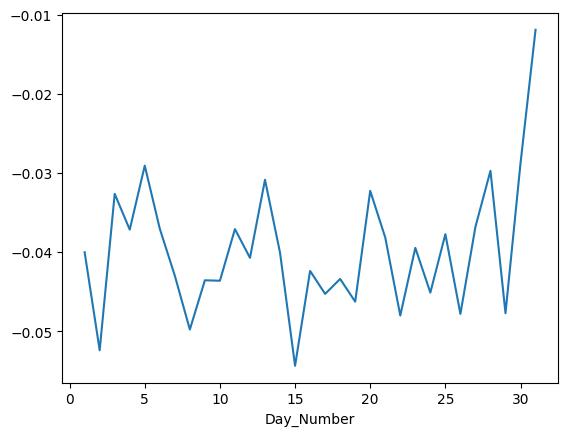

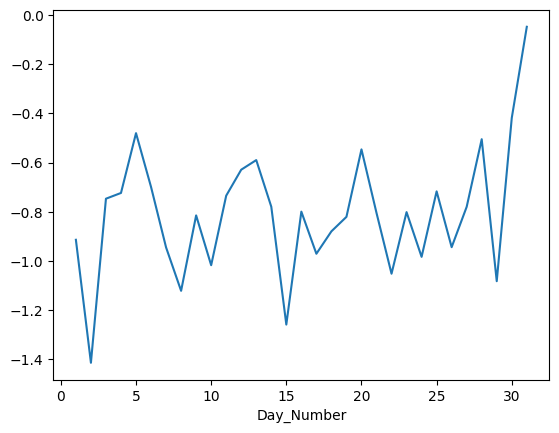

,Test_Period_Ahead_Sharpe_Mean,Test_Period_Ahead_Sharpe_Count,Test_Period_Ahead_Return_Mean,Test_Period_Ahead_Return_Count
Day_Number,,,,
31,-0.011913,9,-0.047231,9
30,-0.028767,15,-0.418106,15
5,-0.029079,15,-0.480161,15
28,-0.029727,16,-0.504836,16
13,-0.030861,16,-0.589746,16
20,-0.032265,16,-0.546224,16
3,-0.032642,13,-0.746930,13
27,-0.036811,14,-0.779975,14
6,-0.037048,16,-0.699161,16


In [34]:
aggregate_per_index(data_sharpe, 'Day_Number')

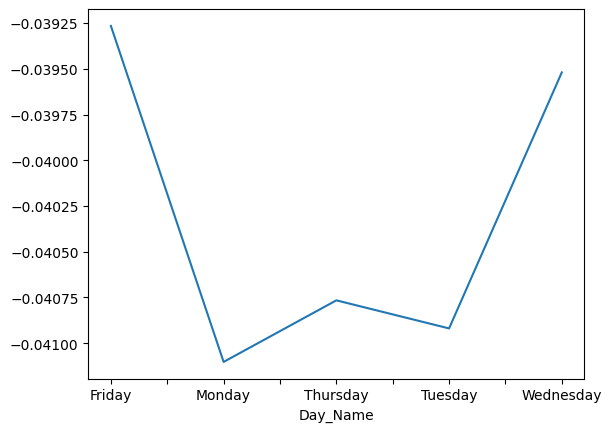

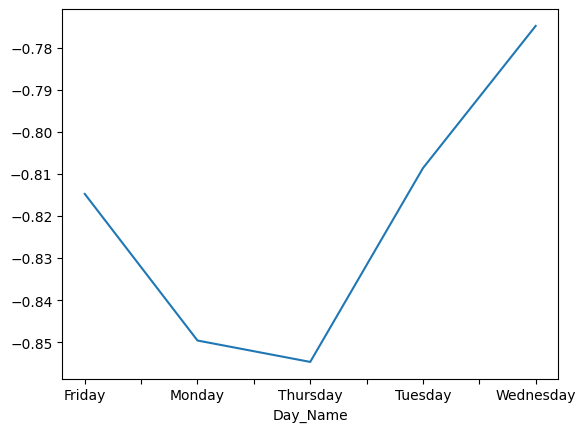

,Test_Period_Ahead_Sharpe_Mean,Test_Period_Ahead_Sharpe_Count,Test_Period_Ahead_Return_Mean,Test_Period_Ahead_Return_Count
Day_Name,,,,
Friday,-0.039265,100,-0.814747,100
Wednesday,-0.039520,104,-0.774807,104
Thursday,-0.040766,102,-0.854689,102
Tuesday,-0.040919,102,-0.808617,102
Monday,-0.041102,92,-0.849600,92


In [35]:
aggregate_per_index(data_sharpe, 'Day_Name')

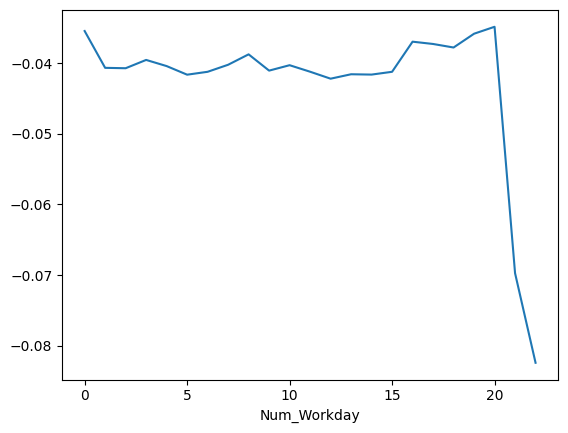

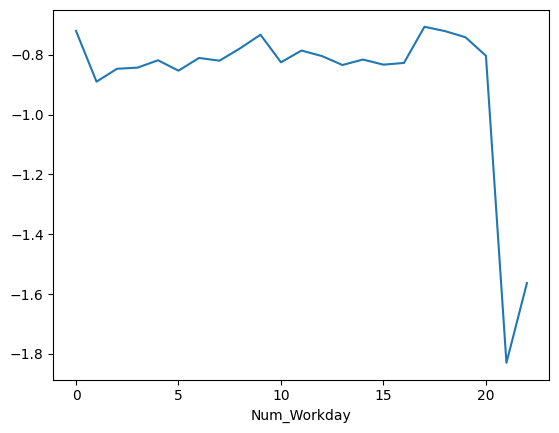

,Test_Period_Ahead_Sharpe_Mean,Test_Period_Ahead_Sharpe_Count,Test_Period_Ahead_Return_Mean,Test_Period_Ahead_Return_Count
Num_Workday,,,,
20,-0.034868,16,-0.803235,16
0,-0.035466,24,-0.720138,24
19,-0.035850,22,-0.741216,22
16,-0.036976,24,-0.827141,24
17,-0.037301,24,-0.706330,24
18,-0.037800,24,-0.720775,24
8,-0.038768,24,-0.778584,24
3,-0.039557,23,-0.842912,23
7,-0.040241,24,-0.819691,24


In [36]:
aggregate_per_index(data_sharpe, 'Num_Workday')

Results of S&P 500 Total Return Index:

Looking at returns by day number and day name do not seem to be helpful, as the former seems to jump around (in the charts), while the latter looks very similar for each day

From the Num_Workday results:
- Look at rows where average sharpe ratio over the test period is close to 0.6
- Observe we have the best results at around the end of the first week / beginning of the second week (Num_Workday in {3, 4, 5, 6}), and around the third week (Num_Workday in {12, 13, 14, 15, 16})
- Possible explanation: at the start of the month, returns are still affected by month-end flows, which would 'calm down' after the first few business days. 

